In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

In [3]:
cali = fetch_california_housing()
cali_df = pd.DataFrame(cali['data'], columns=cali['feature_names'])
cali_df['Target'] = cali['target']
cali_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [5]:
X, y = cali_df.iloc[:, :-1].values, cali_df.iloc[:, [-1]].values
X.shape, y.shape

((20640, 8), (20640, 1))

In [6]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc.shape, y.shape

((20640, 8), (20640, 1))

In [7]:
X_tensor = torch.from_numpy(X_sc).float()
y_tensor = torch.from_numpy(y).float()

In [8]:
n_epochs = 20000
lr = 1e-3
print_interval = 1000

In [9]:
class MyModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        super().__init__()

        self.linear1 = nn.Linear(input_dim, 5)
        self.linear2 = nn.Linear(5, 3)
        self.linear3 = nn.Linear(3, output_dim)
        self.act = nn.LeakyReLU(0.01)
    
    def forward(self, x):
        h = self.act(self.linear1(x))
        h = self.act(self.linear2(h))
        h = self.linear3(h)
        return y

In [10]:
model = MyModel(X_tensor.size(-1), y_tensor.size(-1))
print(model)

MyModel(
  (linear1): Linear(in_features=8, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=1, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)


In [12]:
model = nn.Sequential(
    nn.Linear(X_tensor.size(-1), 5),
    nn.LeakyReLU(0.01),
    nn.Linear(5, 3),
    nn.LeakyReLU(0.01),
    nn.Linear(3, y_tensor.size(-1))
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=5, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=5, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=1, bias=True)
)


In [13]:
opt = optim.Adam(model.parameters(), lr=lr)

In [14]:
for i in range(n_epochs):
    y_hat = model(X_tensor)
    loss = F.mse_loss(y_hat, y_tensor)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (i+1) % print_interval == 0:
        print(f'Epoch {i+1}: loss={loss:.4f}')

Epoch 1000: loss=0.4492
Epoch 2000: loss=0.4007
Epoch 3000: loss=0.3688
Epoch 4000: loss=0.3576
Epoch 5000: loss=0.3513
Epoch 6000: loss=0.3468
Epoch 7000: loss=0.3420
Epoch 8000: loss=0.3408
Epoch 9000: loss=0.3406
Epoch 10000: loss=0.3405
Epoch 11000: loss=0.3405
Epoch 12000: loss=0.3403
Epoch 13000: loss=0.3403
Epoch 14000: loss=0.3403
Epoch 15000: loss=0.3403
Epoch 16000: loss=0.3403
Epoch 17000: loss=0.3403
Epoch 18000: loss=0.3403
Epoch 19000: loss=0.3403
Epoch 20000: loss=0.3403


In [19]:
result_df = pd.DataFrame(torch.concat([y_tensor, y_hat], dim=1).detach().numpy(), columns=['y', 'y_hat']).clip(lower=0, upper=5)
result_df

,y,y_hat
0,4.526,4.259798
1,3.585,4.495434
2,3.521,4.434410
3,3.413,3.658854
4,3.422,2.990054
...,...,...
20635,0.781,0.688644
20636,0.771,0.813570
20637,0.923,0.813688
20638,0.847,0.885585


c:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\admin\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_con

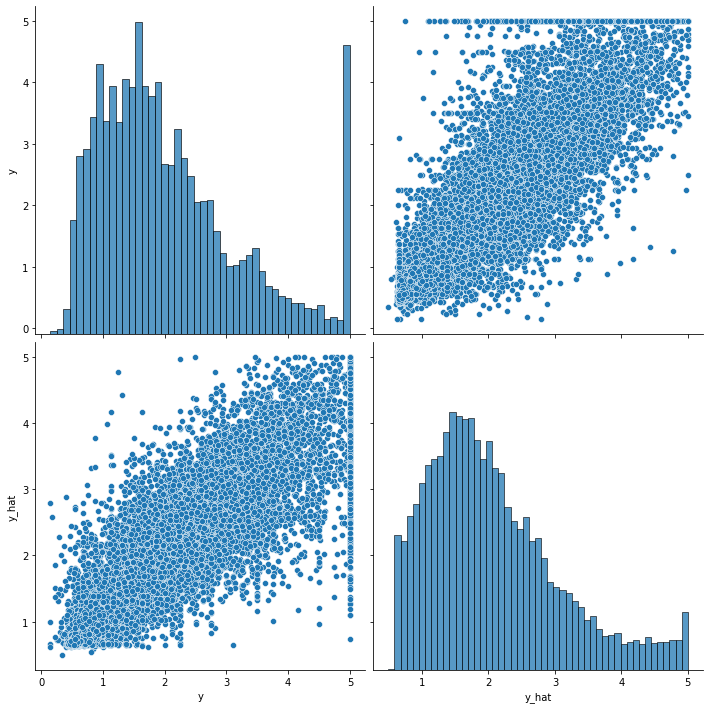

In [20]:
sns.pairplot(result_df, height=5)
plt.show()

In [22]:
result_df.describe()

,y,y_hat
count,20640.000000,20640.000000
mean,2.068558,2.066731
std,1.153962,0.991039
min,0.149990,0.493277
25%,1.196000,1.335625
50%,1.797000,1.869678
75%,2.647250,2.600468
max,5.000000,5.000000


In [25]:
(result_df['y'] == 5).sum()

992